# SIMPLE BACKPROPAGATION MODEL

In [38]:
# from Karpathies micrograd engine. 

import math

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [39]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# Simple model

The following is a simple model with two neurons arranged linearly like this:




Input -> Neuron_1 -> Neuron2 (output)

And I wanted to demonstrate a simple gate like this:

1 -> 0

0 -> 1

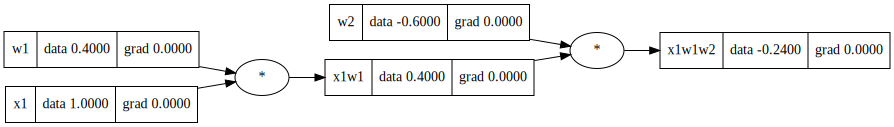

In [40]:
# example 1: 1 -> 0

w1 = Value(0.4,label='w1')
w2 = Value(-0.6,label='w2')
x1 = Value(1.0,label='x1')


x1w1 = x1*w1; x1w1.label = 'x1w1'

x1w1w2 = x1w1 * w2; x1w1w2.label = 'x1w1w2'

draw_dot(x1w1w2)

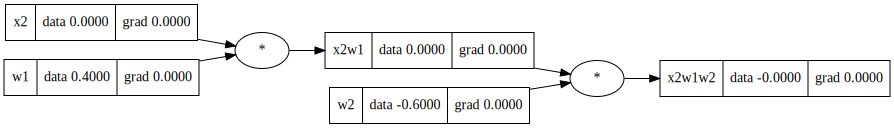

In [41]:
# input 2: 0 -> 1

x2 = Value(0.0,label='x2')

x2w1 = x2*w1; x2w1.label = 'x2w1'

x2w1w2 = x2w1 * w2; x2w1w2.label = 'x2w1w2'

draw_dot(x2w1w2)

In [42]:
# these are the expected outputs

y_real_1= Value(0.0,label = 'y_real_1')
y_real_2 = Value(1.0,label = 'y_real_2')

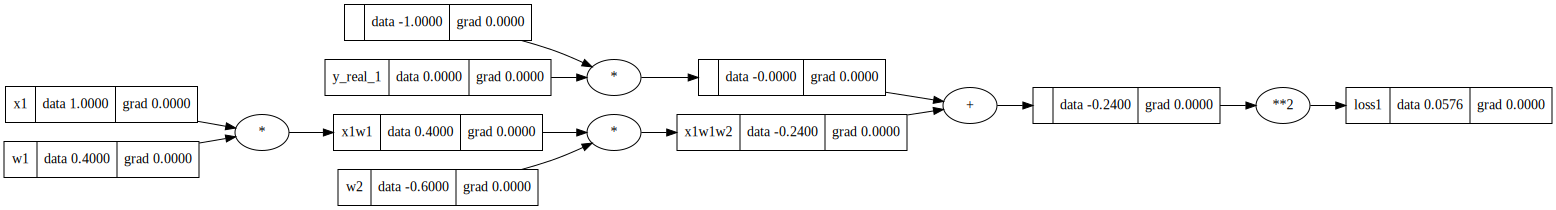

In [43]:
# this is the loss funtion of input 1! I used mean squared error

loss1 = (x1w1w2 - y_real_1) **2 ; loss1.label = 'loss1'
draw_dot(loss1)

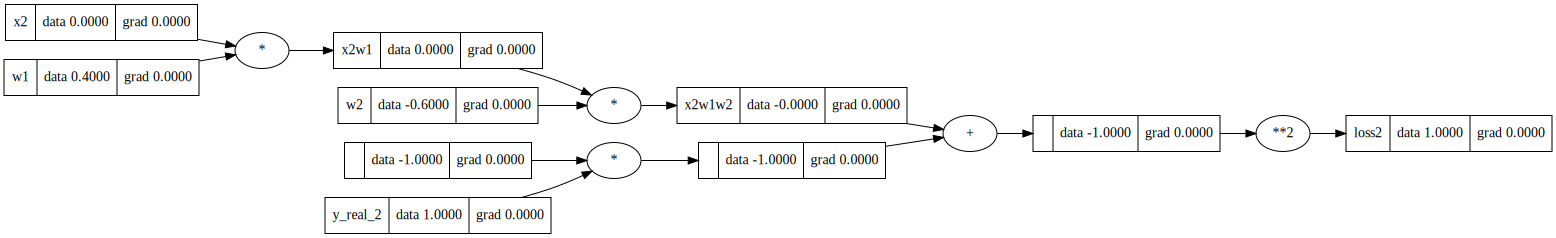

In [44]:
# this is the loss funtion of input 2, again with mean squared error:

loss2 = (x2w1w2 - y_real_2) **2 ; loss2.label = 'loss2'
draw_dot(loss2)

In [45]:
# the total loss is just a sum of the losses

total_loss = loss1+ loss2; total_loss.label = 'total_loss'

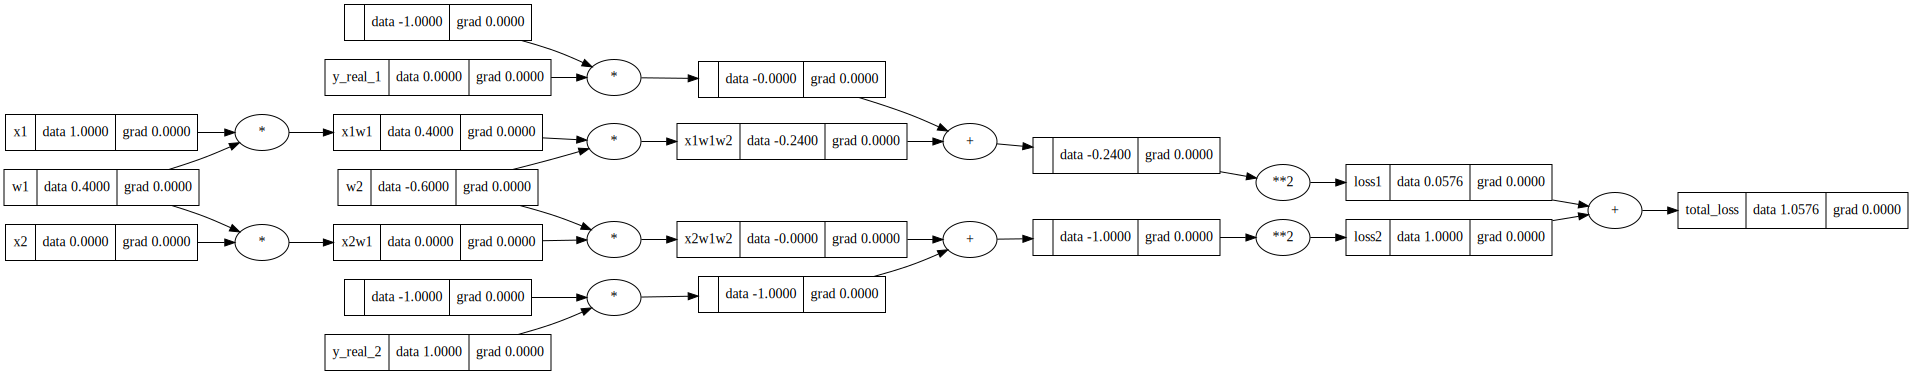

In [46]:
draw_dot(total_loss)

In [47]:
# this is the gradient of the sum of the loss functions with respect to the the weights and all the other parameters

total_loss.backward()

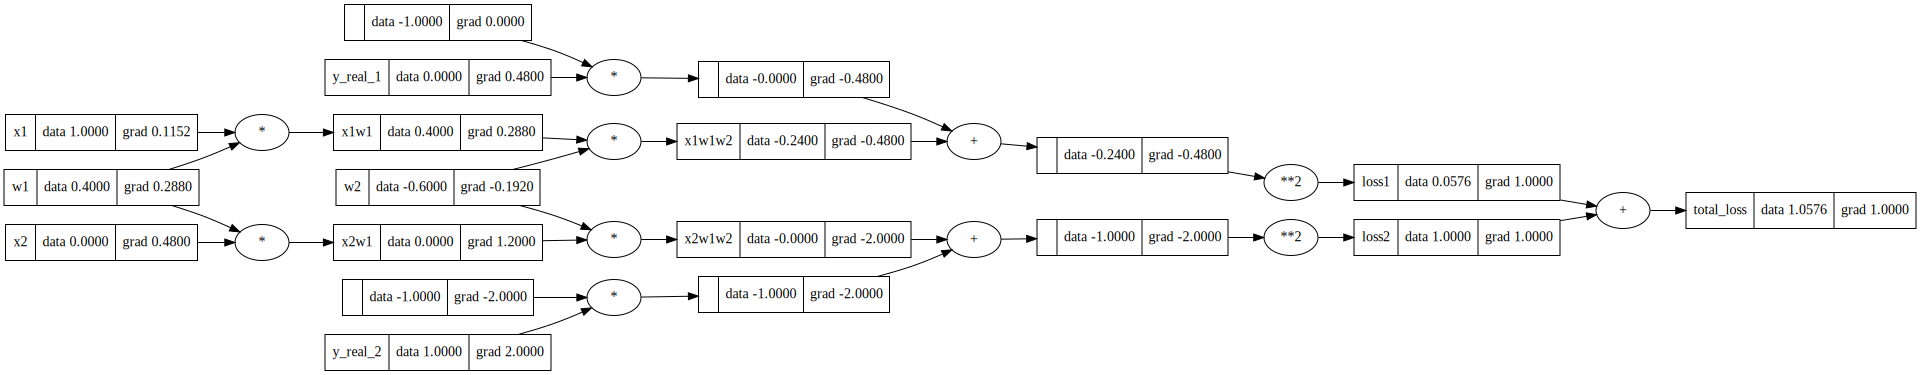

In [48]:
draw_dot(total_loss)

# Learning: is it possible?

I thought a lot about this. This is a linear model, is there really such a number I can multiply by a number (my weights) to get my desired output? Its impossible. But what if I just do the learning what will happen. Even better, what does this function look like when its graphed?


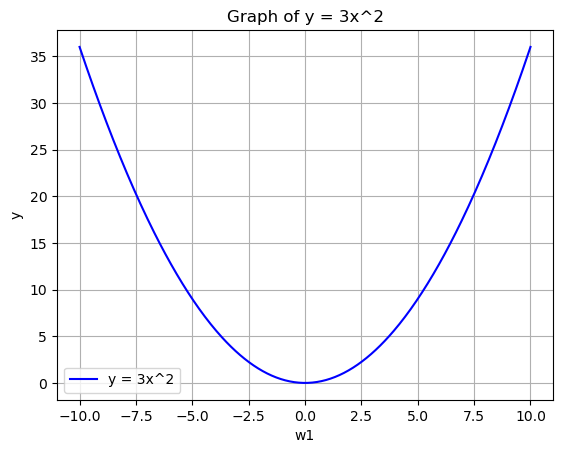

In [49]:
# wait if i have the loss function and the weight i can just graph it?
# lets try that first and then do the back propagation

import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(w):
    return (-0.6*w)**2

# Generate x values
w = np.linspace(-10, 10, 400)  # Generates 400 points between -10 and 10

# Calculate y values
y = f(w)

# Plot the function
plt.plot(w, y, label="y = 3x^2", color="blue")
plt.xlabel("w1")
plt.ylabel("y")
plt.title("Graph of y = 3x^2")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# actually never mind i forgot that we need both inputs to go thorugh the same weights
# lets do the backprop now
w1_total = [w1.data]
w2_total = [w2.data]
all_losses = [total_loss.data]

In [53]:


for i in range(10):
    #updating gradients
    w1.data = -0.01 * w1.grad
    w2.data = -0.01 * w2.grad
    w1_total.append(w1.data)
    w2_total.append(w2.data)

    # feedforward with new weights
    x1w1 = x1*w1; x1w1.label = 'x1w1'
    x1w1w2 = x1w1 * w2; x1w1w2.label = 'x1w1w2'
    x2w1 = x2*w1; x2w1.label = 'x2w1'
    x2w1w2 = x2w1 * w2; x2w1w2.label = 'x2w1w2'
    
    # calculating loss
    loss1 = (x1w1w2 - y_real_1) **2 ; loss1.label = 'loss1'
    loss2 = (x2w1w2 - y_real_2) **2 ; loss2.label = 'loss2'
    total_loss = loss1+ loss2; total_loss.label = 'total_loss'
    all_losses.append(total_loss.data)
    total_loss.backward()

In [54]:
print(all_losses)
print(w1_total)
print(w2_total)

[1.0576, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305764, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.0000000000305762, 1.000000000030576, 1.000000000030576, 1.000000000030576, 1.000000000030576]
[0.4, -0.0028799999999999997, -0.0028799997876633597, -0.002879999575326806, -0.002879999362990338, -0.002879999150653956, -0.0028799989383176605, -0.0028799987259814507, -0.0028799985136453276, -0.002879998301309291, -0.0028799980889733395, -0.0028799978766374744, -0.0028799976643016957, -0.002879997451966003, -0.002879997239630396, -0.002879997027294875, -0.0028799968149594403, -0.002879996

In [55]:

# feedforward with new weights
x1w1 = x1*w1; x1w1.label = 'x1w1'
x1w1w2 = x1w1 * w2; x1w1w2.label = 'x1w1w2'
x2w1 = x2*w1; x2w1.label = 'x2w1'
x2w1w2 = x2w1 * w2; x2w1w2.label = 'x2w1w2'

print(x1w1w2)
print(x2w1w2)
    

Value(data=-5.5295615758023185e-06)
Value(data=-0.0)


# It makese sense that this doesnt work because there is no such number where if I multiple 1 i get 0 and if i multiple 0 i get one. but it should work if there is a bias. So I will try again with a bias.

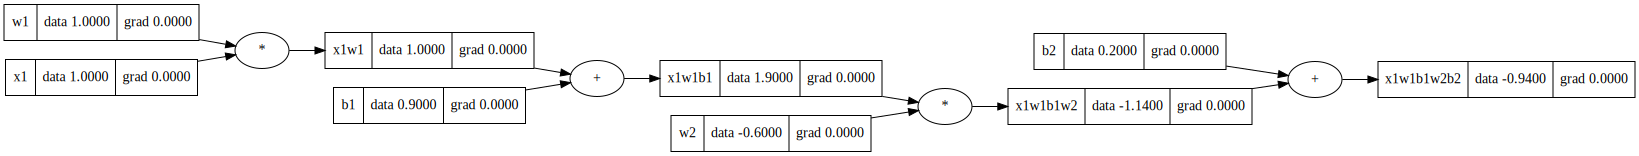

In [678]:
# example 1: 1 -> 0

w1 = Value(1.0,label='w1')
w2 = Value(-0.6,label='w2')
b1 = Value(0.9,label='b1')
b2 = Value(0.2,label='b2')
x1 = Value(1.0,label='x1')
x2 = Value(0.0,label='x2')


x1w1 = x1*w1 ; x1w1.label = 'x1w1'

x1w1b1 = x1w1 + b1 ; x1w1b1.label = 'x1w1b1'

x1w1b1w2 = x1w1b1 * w2 ;  x1w1b1w2.label = 'x1w1b1w2'

x1w1b1w2b2 = x1w1b1w2 + b2; x1w1b1w2b2.label = 'x1w1b1w2b2'

draw_dot(x1w1b1w2b2)

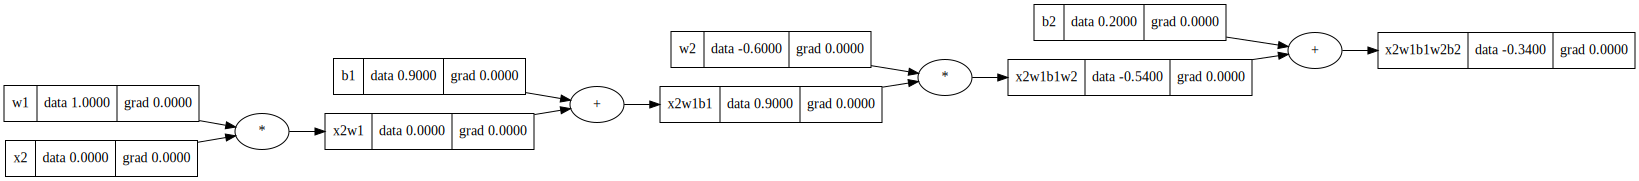

In [679]:
# input 2: 0 -> 1

x2 = Value(0.0,label='x2')


x2w1 = x2*w1 ; x2w1.label = 'x2w1'

x2w1b1 = x2w1 + b1 ; x2w1b1.label = 'x2w1b1'

x2w1b1w2 = x2w1b1 * w2 ;  x2w1b1w2.label = 'x2w1b1w2'

x2w1b1w2b2 = x2w1b1w2 + b2; x2w1b1w2b2.label = 'x2w1b1w2b2'

draw_dot(x2w1b1w2b2)

In [680]:
# these are the expected outputs

y_real_1= Value(0.0,label = 'y_real_1')
y_real_2 = Value(1.0,label = 'y_real_2')

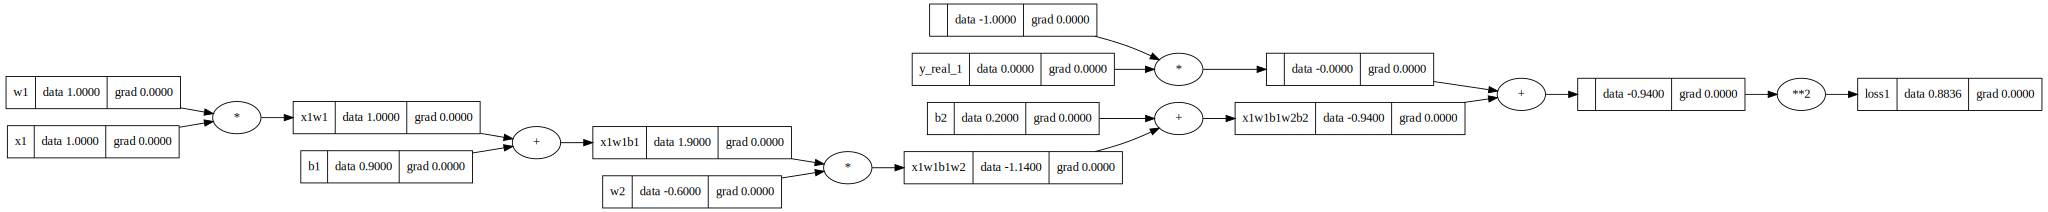

In [681]:
# this is the loss funtion of input 1! I used mean squared error

loss1 = (x1w1b1w2b2 - y_real_1) **2 ; loss1.label = 'loss1'
draw_dot(loss1)

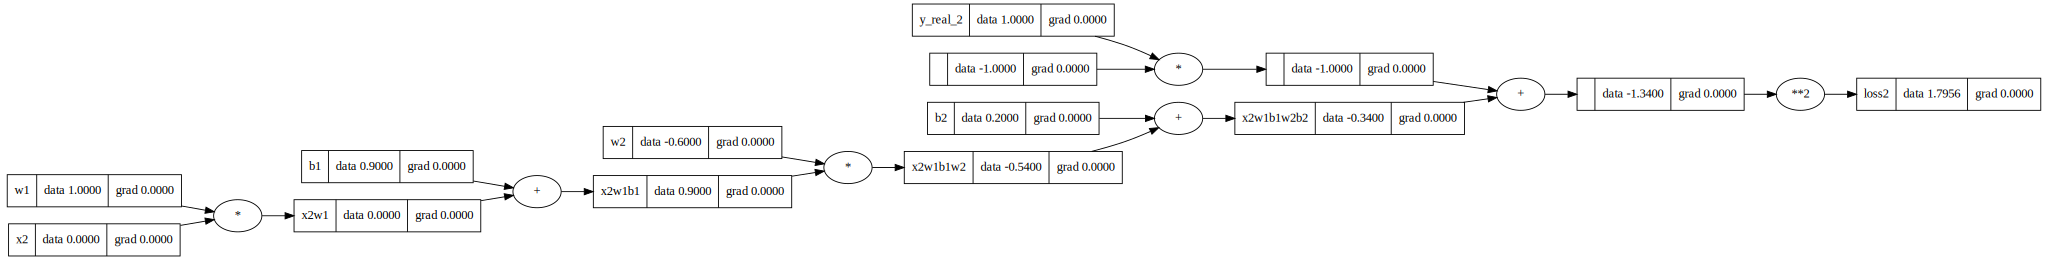

In [682]:
# this is the loss funtion of input 2, again with mean squared error:

loss2 = (x2w1b1w2b2 - y_real_2) **2 ; loss2.label = 'loss2'
draw_dot(loss2)

In [683]:
# the total loss is just a sum of the losses

total_loss = loss1+ loss2; total_loss.label = 'total_loss'

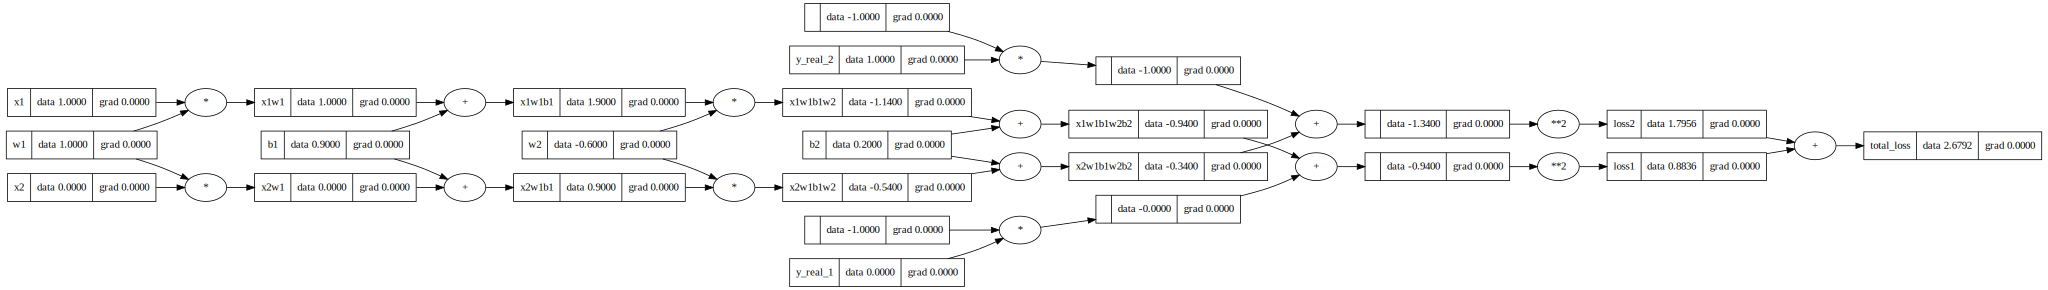

In [684]:
draw_dot(total_loss)

In [685]:
# this is the gradient of the sum of the loss functions with respect to the the weights and all the other parameters

total_loss.backward()

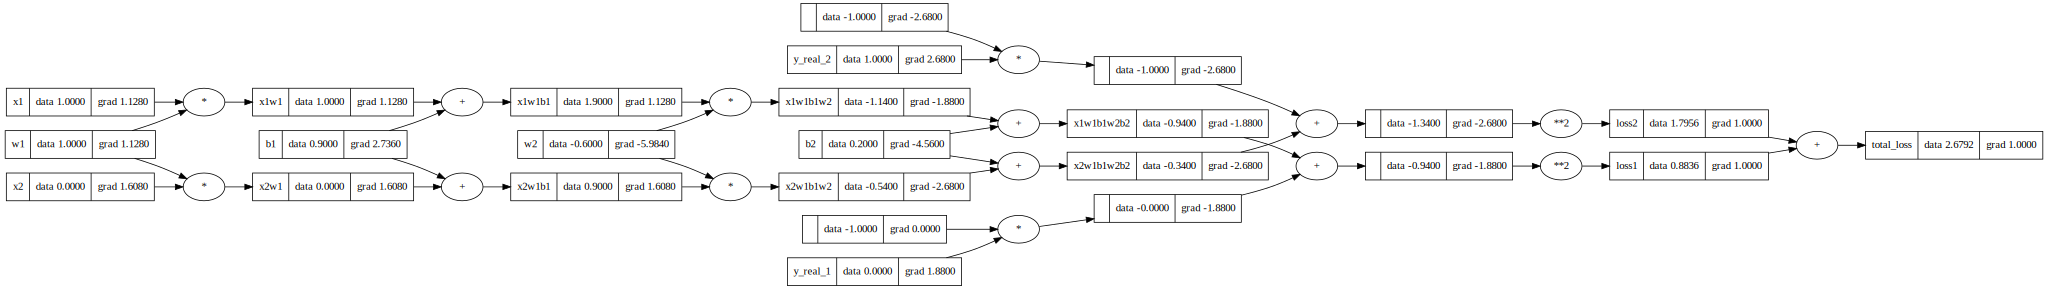

In [686]:
draw_dot(total_loss)

In [687]:
# backward pass:


w1_total = [w1.data]
w2_total = [w2.data]

b1_total = [b1.data]
b2_total = [b2.data]
all_losses = [total_loss.data]

In [688]:


for i in range(50):
    #updating gradients
    w1.data += -0.01 * w1.grad
    w2.data += -0.01 * w2.grad
    b1.data += -0.01 * b1.grad
    b2.data += -0.01 * b2.grad
    w1_total.append(w1.data)
    w2_total.append(w2.data)
    b1_total.append(b1.data)
    b2_total.append(b2.data)

    
    
    x1w1 = x1*w1 ; x1w1.label = 'x1w1'
    x1w1b1 = x1w1 + b1 ; x1w1b1.label = 'x1w1b1'
    x1w1b1w2 = x1w1b1 * w2 ;  x1w1b1w2.label = 'x1w1b1w2'
    x1w1b1w2b2 = x1w1b1w2 + b2; x1w1b1w2b2.label = 'x1w1b1w2b2'
    
        
    x2w1 = x2*w1 ; x2w1.label = 'x2w1'
    x2w1b1 = x2w1 + b1 ; x2w1b1.label = 'x2w1b1'
    x2w1b1w2 = x2w1b1 * w2 ;  x2w1b1w2.label = 'x2w1b1w2'
    x2w1b1w2b2 = x2w1b1w2 + b2; x2w1b1w2b2.label = 'x2w1b1w2b2'


    # calculating loss
    loss1 = (x1w1b1w2b2 - y_real_1) **2 ; loss1.label = 'loss1'
    loss2 = (x2w1b1w2b2 - y_real_2) **2 ; loss2.label = 'loss2'
    total_loss = loss1+ loss2; total_loss.label = 'total_loss'
    all_losses.append(total_loss.data)
    total_loss.backward()

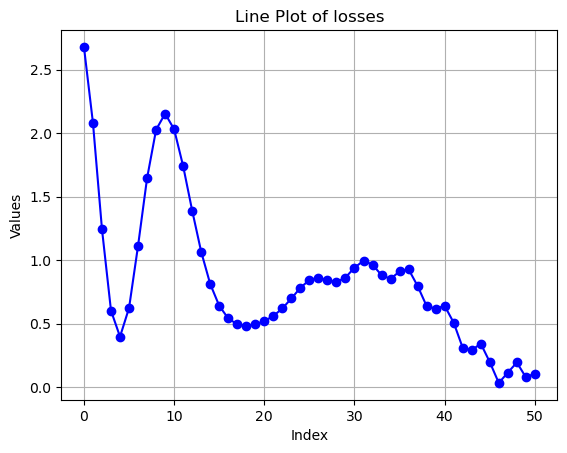

In [689]:
# print(all_losses)
# print(w1_total)
# print(w2_total)

x = range(len(all_losses))  # Generates x values as [0, 1, 2] to match the indices of y

# Plot
plt.plot(x, all_losses, marker='o', color='blue')  # 'marker' to show each data point
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Line Plot of losses")
plt.grid(True)
plt.show()

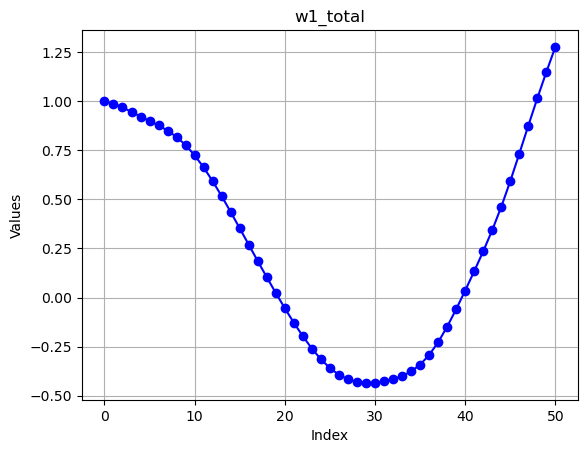

In [690]:
# print(all_losses)
# print(w1_total)
# print(w2_total)

x = range(len(w1_total))  # Generates x values as [0, 1, 2] to match the indices of y

# Plot
plt.plot(x, w1_total, marker='o', color='blue')  # 'marker' to show each data point
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("w1_total")
plt.grid(True)
plt.show()

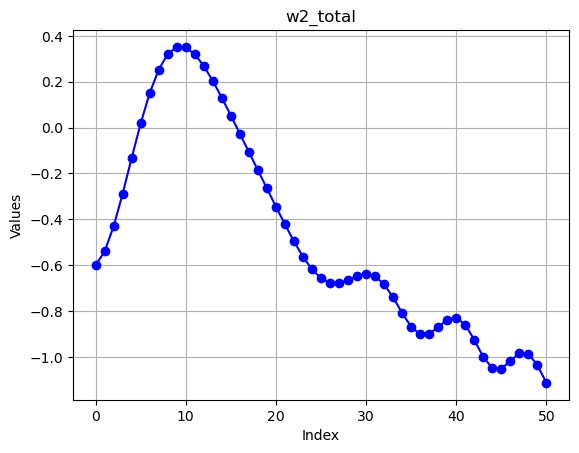

In [691]:
# print(all_losses)
# print(w1_total)
# print(w2_total)

x = range(len(w2_total))  # Generates x values as [0, 1, 2] to match the indices of y

# Plot
plt.plot(x, w2_total, marker='o', color='blue')  # 'marker' to show each data point
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("w2_total")
plt.grid(True)
plt.show()

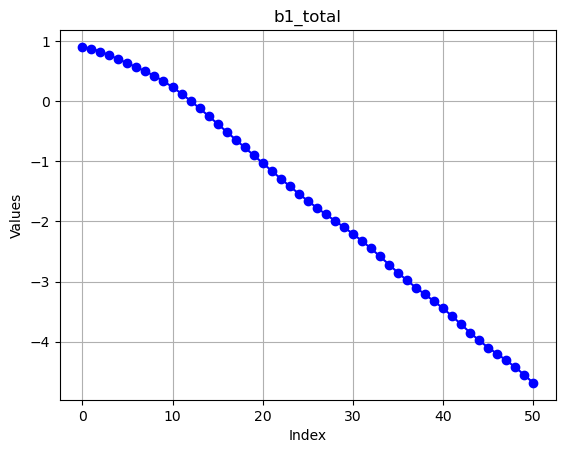

In [692]:
# print(all_losses)
# print(w1_total)
# print(w2_total)

x = range(len(b1_total))  # Generates x values as [0, 1, 2] to match the indices of y

# Plot
plt.plot(x, b1_total, marker='o', color='blue')  # 'marker' to show each data point
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("b1_total")
plt.grid(True)
plt.show()

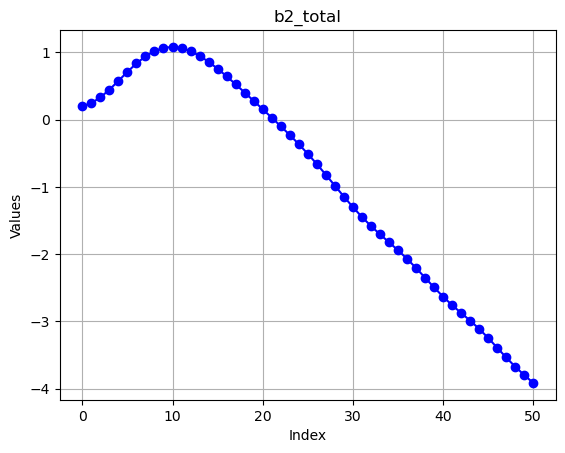

In [693]:
# print(all_losses)
# print(w1_total)
# print(w2_total)

x = range(len(b1_total))  # Generates x values as [0, 1, 2] to match the indices of y

# Plot
plt.plot(x, b2_total, marker='o', color='blue')  # 'marker' to show each data point
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("b2_total")
plt.grid(True)
plt.show()

In [694]:


x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x1w1b1 = x1w1 + b1 ; x1w1b1.label = 'x1w1b1'
x1w1b1w2 = x1w1b1 * w2 ;  x1w1b1w2.label = 'x1w1b1w2'
x1w1b1w2b2 = x1w1b1w2 + b2; x1w1b1w2b2.label = 'x1w1b1w2b2'

    
x2w1 = x2*w1 ; x2w1.label = 'x2w1'
x2w1b1 = x2w1 + b1 ; x2w1b1.label = 'x2w1b1'
x2w1b1w2 = x2w1b1 * w2 ;  x2w1b1w2.label = 'x2w1b1w2'
x2w1b1w2b2 = x2w1b1w2 + b2; x2w1b1w2b2.label = 'x2w1b1w2b2'

In [695]:
print(x1w1b1w2b2)
print(x2w1b1w2b2)

Value(data=-0.11841518271314655)
Value(data=1.303309197399277)


In [696]:
total_loss.data

0.10601862472398144

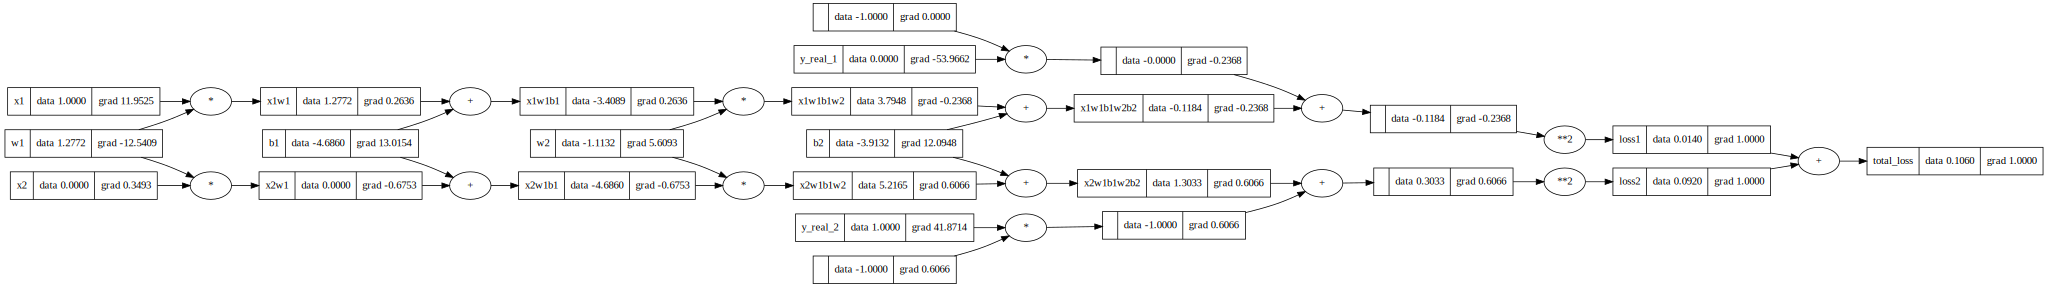

In [697]:
draw_dot(total_loss)

In [698]:
# ah so maybe it was not true and i cannot 
# no i checked these are the correct values exist so something aint right above


w1 = Value(-1,label='w1')
w2 = Value(1,label='w2')
b1 = Value(0,label='b1')
b2 = Value(1,label='b2')
x1 = Value(1.0,label='x1')
x2 = Value(0.0,label='x2')





x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x1w1b1 = x1w1 + b1 ; x1w1b1.label = 'x1w1b1'
x1w1b1w2 = x1w1b1 * w2 ;  x1w1b1w2.label = 'x1w1b1w2'
x1w1b1w2b2 = x1w1b1w2 + b2; x1w1b1w2b2.label = 'x1w1b1w2b2'

    
x2w1 = x2*w1 ; x2w1.label = 'x2w1'
x2w1b1 = x2w1 + b1 ; x2w1b1.label = 'x2w1b1'
x2w1b1w2 = x2w1b1 * w2 ;  x2w1b1w2.label = 'x2w1b1w2'
x2w1b1w2b2 = x2w1b1w2 + b2; x2w1b1w2b2.label = 'x2w1b1w2b2'

In [699]:
print(x1w1b1w2b2)
print(x2w1b1w2b2)

Value(data=0.0)
Value(data=1.0)
